In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
)
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import xgboost as xgb

In [2]:
df = pd.read_csv("student_training_dataset_realistic_perfect.csv")
print("Dataset loaded successfully!")
print("Shape:", df.shape)
df.head()

Dataset loaded successfully!
Shape: (2000, 13)


,student_id,name,branch,cgpa,avg_test_score,technical_score,aptitude_score,num_projects,num_internships,skills,placed,company,salary
0,S0488,Priya,CIVIL,8.66,67.75,77.36,47.40,5,0,"AutoCAD, STAAD, Surveying",0,NaN,0
1,S1860,Aisha,ECE,6.61,76.75,58.04,44.92,2,0,"Embedded, C++, Verilog",1,Wipro,493668
2,S1480,Diya,MECH,8.00,80.97,66.24,60.96,1,1,"Python, AutoCAD, MATLAB",0,NaN,0
3,S0252,Ananya,CSE,5.50,54.42,69.26,55.62,3,0,"Python, DL, ML",1,Wipro,493402
4,S0071,Karan,MECH,6.57,47.17,78.90,67.95,3,0,"SolidWorks, Python, MATLAB",1,HCL,436250


In [ ]:
# defining features and targets
X = df[["cgpa","avg_test_score","technical_score","aptitude_score",
        "num_projects","num_internships","branch"]]
y = df["placed"] 

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print("Train size:", X_train.shape, "| Test size:", X_test.shape)

Train size: (1600, 7) | Test size: (400, 7)


In [5]:
# preprocessing
numeric_features = ["cgpa","avg_test_score","technical_score","aptitude_score","num_projects","num_internships"]
categorical_features = ["branch"]

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numeric_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
])


In [6]:
# XGBoost model
model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=42
)

pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", model)
])

In [7]:
pipe.fit(X_train, y_train)
print("Model trained successfully!")

/Users/kaivalyasatav/Downloads/placement_app/.venv/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [11:52:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Model trained successfully!


In [8]:
y_pred = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)[:, 1]

In [9]:
acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)

In [11]:
print("\nModel Evaluation Metrics")
print(f"Accuracy: {acc:.4f}")
print(f"AUC Score: {auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Model Evaluation Metrics
Accuracy: 0.8250
AUC Score: 0.8806

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.63      0.72       140
           1       0.82      0.93      0.87       260

    accuracy                           0.82       400
   macro avg       0.83      0.78      0.79       400
weighted avg       0.83      0.82      0.82       400



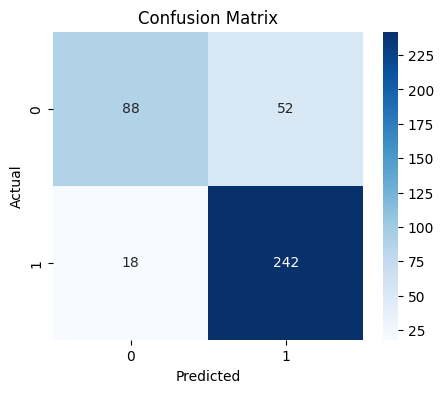

In [12]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

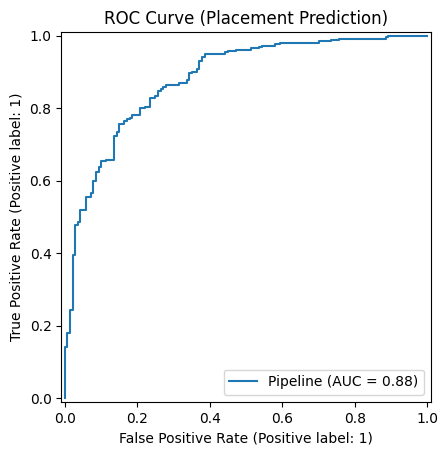

In [13]:
RocCurveDisplay.from_estimator(pipe, X_test, y_test)
plt.title("ROC Curve (Placement Prediction)")
plt.show()

In [14]:
cv_scores = cross_val_score(pipe, X, y, cv=5, scoring='roc_auc')
print(f"\n📈 5-Fold Cross-Validation AUC Scores: {cv_scores}")
print(f"Mean AUC: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

/Users/kaivalyasatav/Downloads/placement_app/.venv/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [11:53:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/kaivalyasatav/Downloads/placement_app/.venv/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [11:53:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/kaivalyasatav/Downloads/placement_app/.venv/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [11:53:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/kaivalyasatav/Downloads/placement_app/.venv/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [11:53:25] WARN


📈 5-Fold Cross-Validation AUC Scores: [0.83700549 0.82266484 0.84373626 0.84876374 0.82662088]
Mean AUC: 0.8358 ± 0.0099
